## Read data from sat measurement

In [9]:
%load_ext autoreload
%autoreload 1

%aimport dti_util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os, glob, numpy as np
import yaml
from dti_util import default, stack_training
import matplotlib.pyplot as plt
import matplotlib as mpl
# Change default matplotlib
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['savefig.pad_inches']=0.1
mpl.rcParams['axes.labelsize']=mpl.rcParams['axes.titlesize']

In [11]:
# Name of the experiment
name = 'exp-sr-sat-hr-smallpatch'

# Root of all directory used
rootdir = '/mnt/sfe-ns9602k/Julien/data'

# Directory of the experiment outputs
expdir = os.path.join(rootdir, name)

# List of keys in the dictionnary of the experiment
list_of_params = ['dsize']

# Load exp setting
with open(os.path.join(expdir,'data_params.yml')) as file:
    exp_dict= yaml.load(file, Loader=yaml.FullLoader)    
    
exp_dict = {**default,**exp_dict}

# Set the variables from the dict
for k in list_of_params:
    if k in exp_dict:
        exec(k+' = exp_dict[k]')
    else:
        exec(k+' = default[k]')
        
for key, value in exp_dict.items():
    if key in list_of_params:
        print(key, ' : ', value)
        


dsize  :  7


In [12]:
#Set the specifics parameters of sat
load = False

if load:
    pass

else:
    dsat = dict()
    dsat['path'] = os.path.join(expdir, 'sat')
    dsat['datadir'] = os.path.join(rootdir,'anton/sat_data_4cnn')
    dsat['sar'] = False #Use sar data
    dsat['strides_test'] = 1
    dsat['subd'] = 1
    dsat['factors'] = dict(sic=0.01, 
                           divergence_sar=1./(24*60*60), 
                           shear_sar=1./(24*60*60), 
                           divergence=1./(24*60*60),
                        shear=1./(24*60*60))
    dsat['tname'] = 'sat_input_{date}.npz'
    dsat['timname'] = 'sat_image_{date}.npy'
    dsat['outname'] = 'sit_nn_{date}.npy'
    if not os.path.isdir(dsat['path']):
        os.makedirs(dsat['path'])
for key, value in dsat.items():
    print(key, ':', value)
    
# Save the dictionary in yaml format
with open(os.path.join(expdir,'sat_params.yml'),'w') as file:
    yaml.dump(dsat, file)

path : /mnt/sfe-ns9602k/Julien/data/exp-sr-sat-hr-smallpatch/sat
datadir : /mnt/sfe-ns9602k/Julien/data/anton/sat_data_4cnn
sar : False
strides_test : 1
subd : 1
factors : {'sic': 0.01, 'divergence_sar': 1.1574074074074073e-05, 'shear_sar': 1.1574074074074073e-05, 'divergence': 1.1574074074074073e-05, 'shear': 1.1574074074074073e-05}
tname : sat_input_{date}.npz
timname : sat_image_{date}.npy
outname : sit_nn_{date}.npy


In [13]:
# the sorted function should list the images in chronological order
lfiles=list(map(os.path.basename,sorted(glob.glob(os.path.join(dsat['datadir'],'sic_sit_def_*.npz')))))
n = len(lfiles)
print(f'{n} files found')

31 files found


In [14]:
# Load the first sample
sample0 = np.load(os.path.join(dsat['datadir'],lfiles[0]))
ny, nx = sample0['sic'].shape
print(list(sample0.keys()))
for k in sample0.keys():
    print(k,sample0[k].shape)

['sic', 'sit', 'divergence', 'shear', 'divergence_sar', 'shear_sar']
sic (1000, 1000)
sit (1000, 1000)
divergence (1000, 1000)
shear (1000, 1000)
divergence_sar (1000, 1000)
shear_sar (1000, 1000)


In [15]:
# Corresponsdance
suff = '_sar' if dsat['sar'] else ''
mod2sat = dict(
    c='sic',
    h='sit',
    e1_0='divergence'+suff,
    e2_0='shear'+suff)
mod2sat

{'c': 'sic', 'h': 'sit', 'e1_0': 'divergence', 'e2_0': 'shear'}

In [16]:
indx = slice(n)
colnames = [mod2sat[c] for c in exp_dict['colnames']]
othernames = [mod2sat[c] for c in exp_dict['othernames']]
allcols = colnames+othernames

#number of channel (number of predictive features)
nc = len(colnames) 

#number of other features used for masking, diag but not as predictive features
no = len(othernames)

print (allcols)

['shear', 'sic', 'sit', 'divergence', 'sic']


In [17]:


for i,file in enumerate(lfiles[indx]):
    print(i,file)
    sample = np.load(os.path.join(dsat['datadir'],file))
    ny, nx = sample['sic'].shape
    Xall = np.empty((1, ny, nx, nc+no))

    for ic, c in enumerate(allcols):
        if c in dsat['factors']:
            xx = dsat['factors'][c]*sample[c]
        else:
            xx = sample[c]
        Xall[0,:,:,ic] = xx.astype('float32')
    mask_num = np.all(np.isfinite(Xall),axis=3)
    #No other masking implemented (better to mask a posteriori?)
    X = Xall[...,:nc]
    date = file[12:20]

    fname = dsat['timname'].format(date=date)
    np.save(os.path.join(dsat['path'],fname),X)
    Xtest, _, mask_test = stack_training(X, None, mask_num, mask_num, dsize=dsize, 
                                             strides=dsat['strides_test'], subd=dsat['subd'])
    fname = dsat['tname'].format(date=date)
    np.savez(os.path.join(dsat['path'],fname),Xtest=Xtest,mask_test=mask_test,ny=ny, nx=nx)
    

0 sic_sit_def_20210101.npz
1 sic_sit_def_20210201.npz
2 sic_sit_def_20210301.npz
3 sic_sit_def_20210401.npz
4 sic_sit_def_20210501.npz
5 sic_sit_def_20210601.npz
6 sic_sit_def_20210701.npz
7 sic_sit_def_20210801.npz
8 sic_sit_def_20210901.npz
9 sic_sit_def_20211001.npz
10 sic_sit_def_20211101.npz
11 sic_sit_def_20211201.npz
12 sic_sit_def_20211301.npz
13 sic_sit_def_20211401.npz
14 sic_sit_def_20211501.npz
15 sic_sit_def_20211601.npz
16 sic_sit_def_20211701.npz
17 sic_sit_def_20211801.npz
18 sic_sit_def_20211901.npz
19 sic_sit_def_20212001.npz
20 sic_sit_def_20212101.npz
21 sic_sit_def_20212201.npz
22 sic_sit_def_20212301.npz
23 sic_sit_def_20212401.npz
24 sic_sit_def_20212501.npz
25 sic_sit_def_20212601.npz
26 sic_sit_def_20212701.npz
27 sic_sit_def_20212801.npz
28 sic_sit_def_20212901.npz
29 sic_sit_def_20213001.npz
30 sic_sit_def_20213101.npz


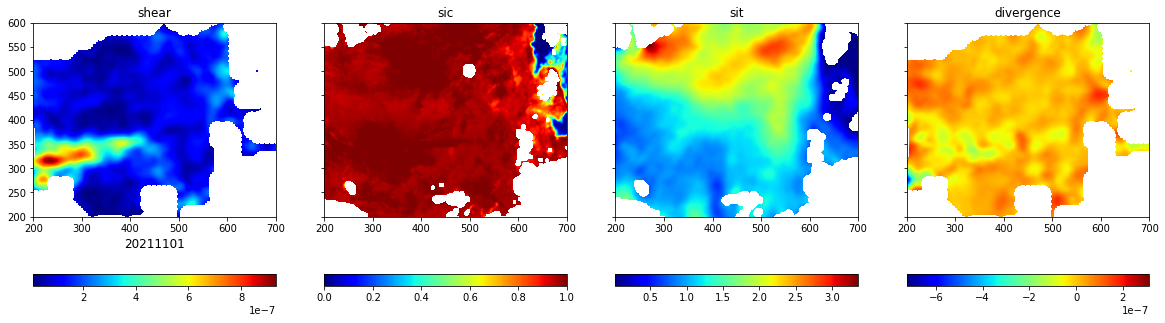

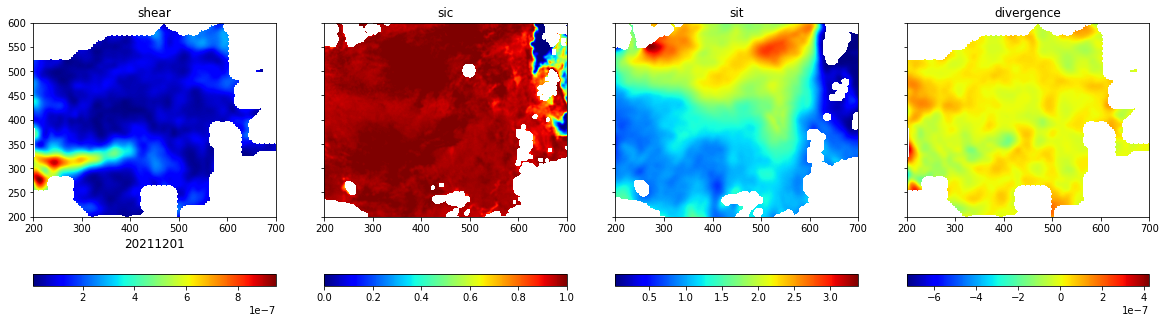

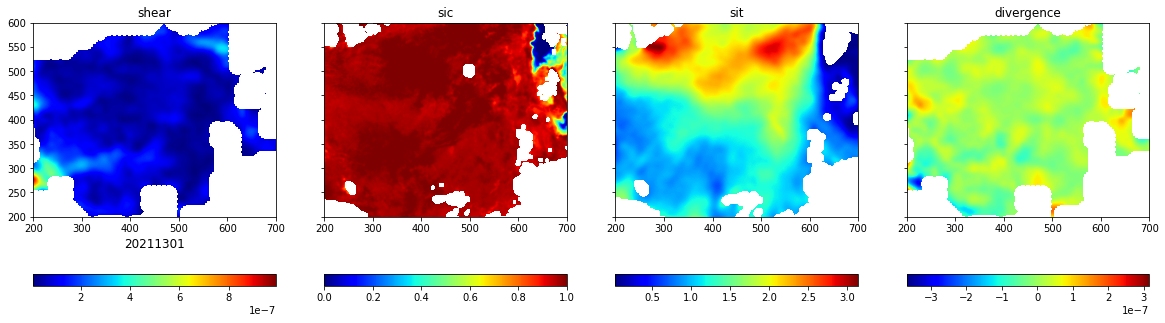

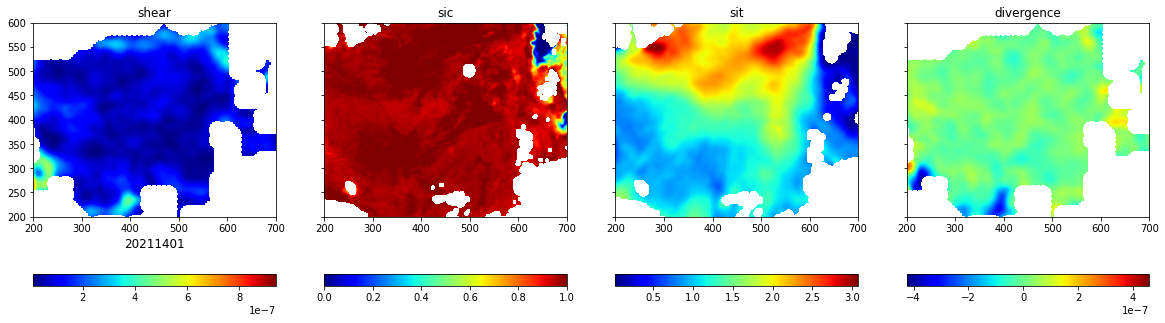

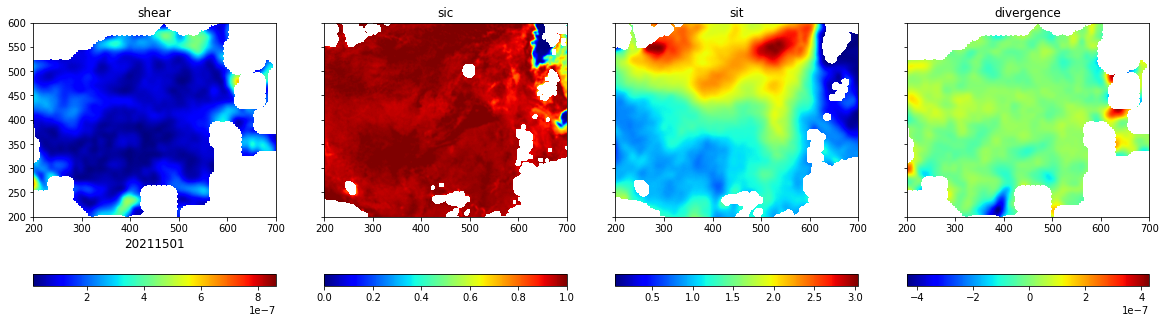

In [18]:
indx=slice(10,15)

for i,file in enumerate(lfiles[indx]):
    date = file[12:20]
    fname = dsat['timname'].format(date=date)
    X = np.load(os.path.join(dsat['path'],fname))
    fig, ax = plt.subplots(ncols=nc,sharey='all',sharex='all',figsize=(5*nc,7))
    for ic, c in enumerate(colnames):
        co=ax[ic].imshow(X[0,...,ic], cmap='jet')
        fig.colorbar(co, ax=ax[ic], orientation='horizontal')
        ax[ic].set_title(c)
        ax[ic].set_xlim((200,700))
        ax[ic].set_ylim((200,600))
        ax[0].set_xlabel(date)

In [19]:
lfiles_mod=list(map(os.path.basename,sorted(glob.glob(os.path.join(exp_dict['datadir'],'field*.npz')))))

#List of date (reverse the order)
ldates_mod = [l[12:14]+l[10:12] for l in lfiles_mod]
Xallmod = np.load(os.path.join(exp_dict['traindir'],'Xall.npy'))



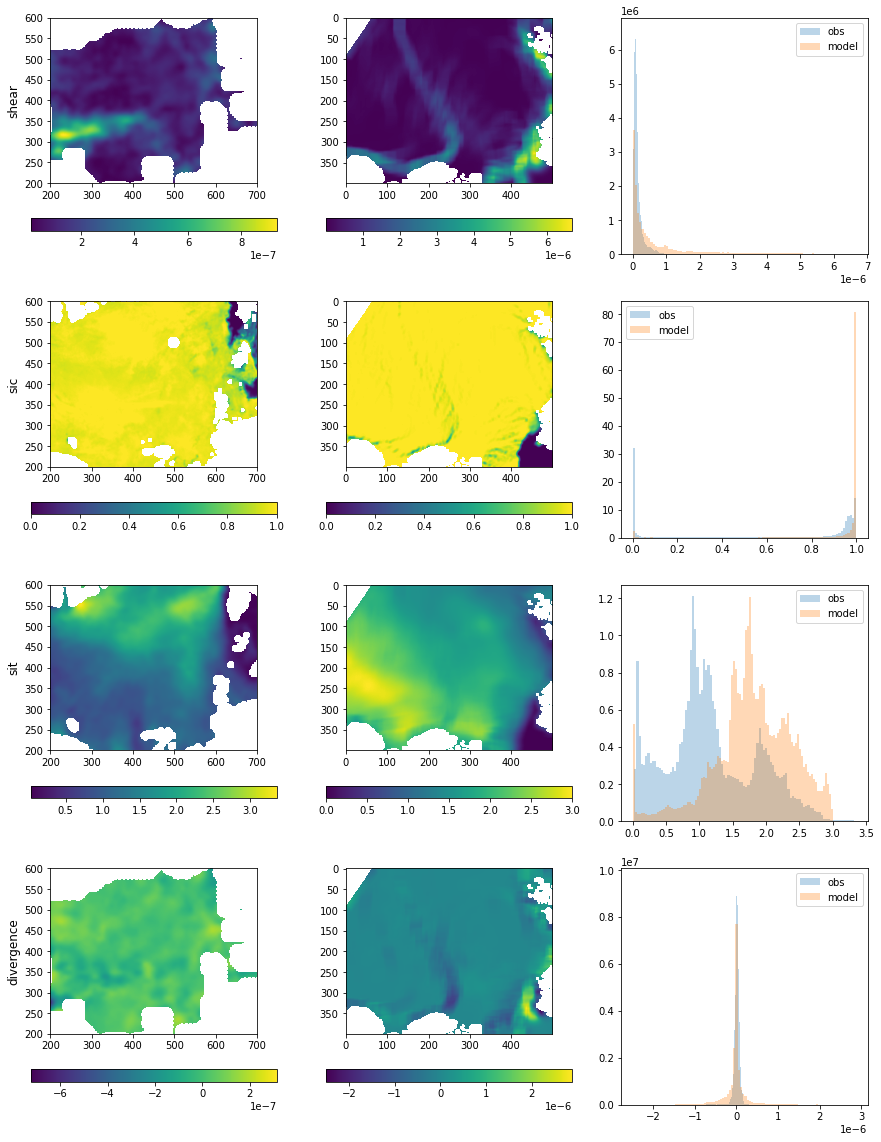

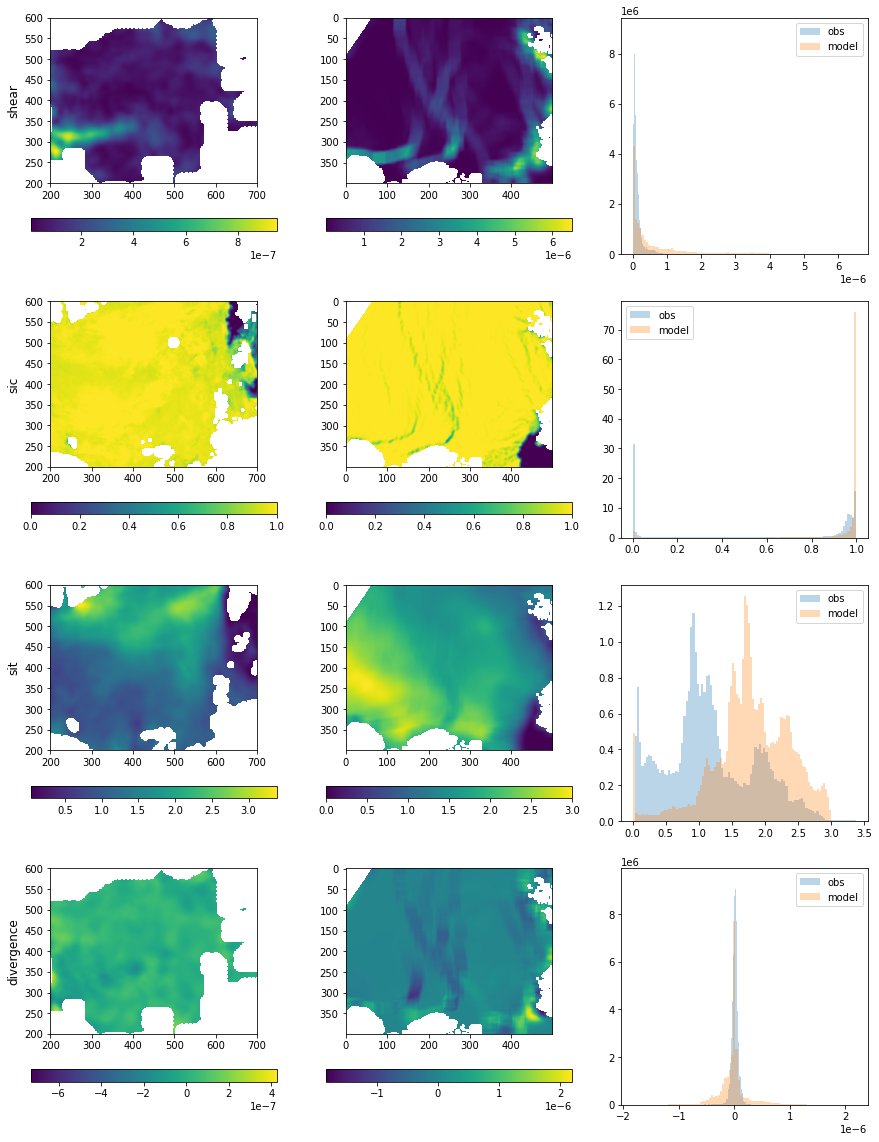

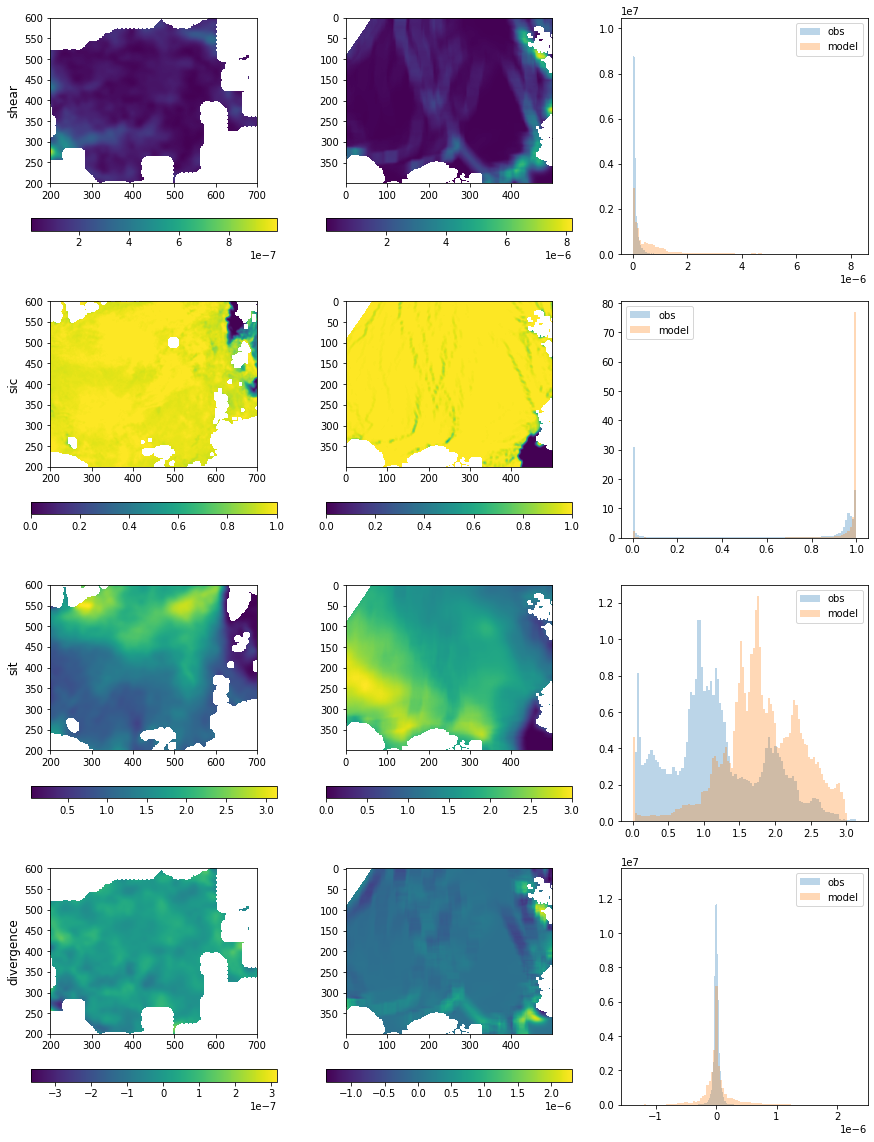

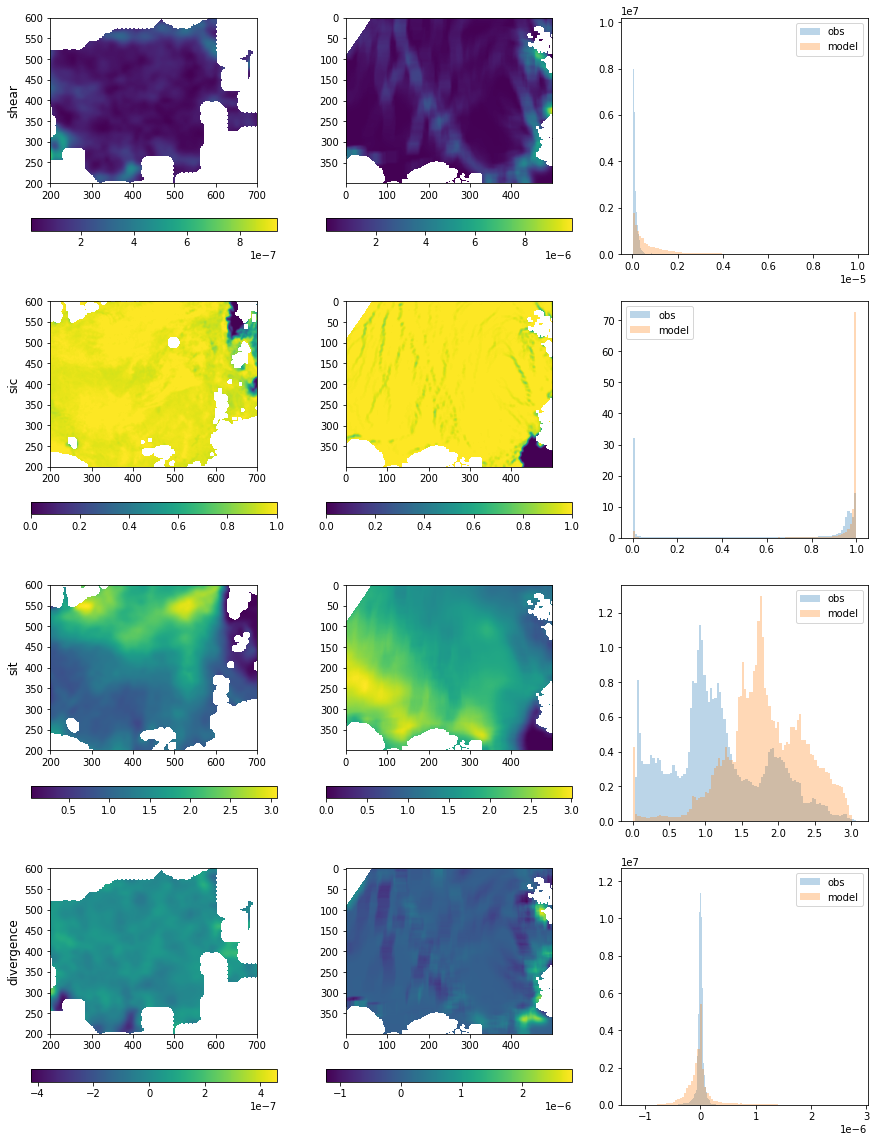

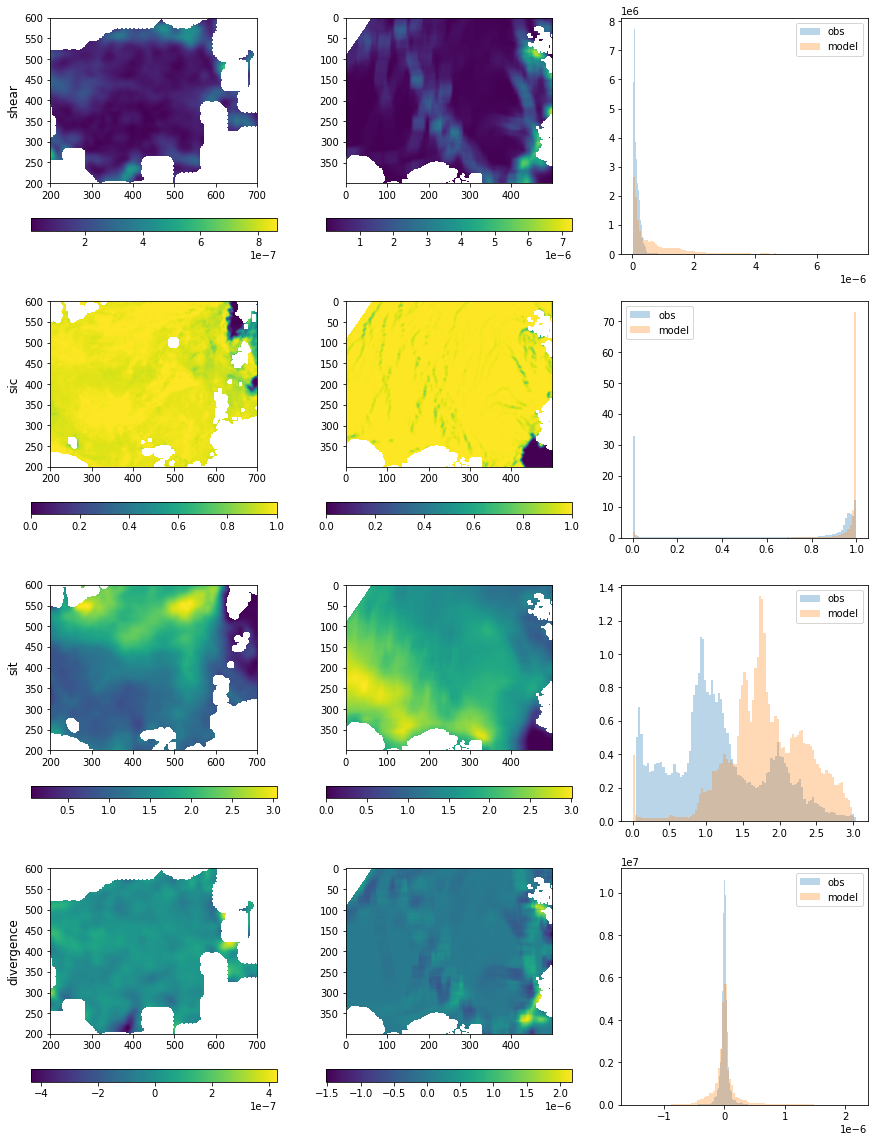

In [20]:
# Compare with model
for i,file in enumerate(lfiles[indx]):
    date = file[12:20]
    fname = dsat['timname'].format(date=date)
    X = np.load(os.path.join(dsat['path'],fname))
    date = file[16:20] #only month/day

    if date in ldates_mod:
        idx = ldates_mod.index(date)
    else:
        continue
    
    fig, ax = plt.subplots(nrows=nc,ncols=3,figsize=(15,nc*5))
    for ic, c in enumerate(exp_dict['colnames']):
        csat = mod2sat[c]
        xx0 = X[0,...,ic]
        xx1 = Xallmod[idx,...,ic]
        ax[ic,0].set_ylabel(csat)
        im0 = ax[ic,0].imshow(xx0)
        ax[ic,0].set_xlim((200,700))
        ax[ic,0].set_ylim((200,600))
        fig.colorbar(im0, ax=ax[ic,0], orientation='horizontal')
                        
        im1=ax[ic,1].imshow(xx1)
        fig.colorbar(im1, ax=ax[ic,1], orientation='horizontal')

        ax[ic,2].hist(xx0[~np.isnan(xx0)],bins=100, alpha=0.3, label='obs', density=True)
        ax[ic,2].hist(xx1[~np.isnan(xx1)],bins=100, alpha=0.3, label='model', density=True)
        ax[ic,2].legend()
    fig.savefig(f'figs/compare_mod_obs_{date}.png')